<a href="https://colab.research.google.com/github/mlaugharn/math189covid19/blob/master/covid_second_wave_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# data sources
# apple maps movement trends
# google maps movement trends
# global policies dataset
# all per state
import pandas as pd
import numpy as np

from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import preprocessing
from functools import reduce
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDRegressor
from sklearn import preprocessing
import pprint
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)

In [2]:
USA = {'Mississippi', 'Virginia', 'South Carolina', 'Massachusetts', 'New Jersey', 'Arkansas', 'Tennessee', 'Hawaii', 'South Dakota', 'Alaska', 'North Dakota', 'Kansas', 'Utah', 'Texas', 'Louisiana', 'District of Columbia', 'Wyoming', 'Oklahoma', 'Pennsylvania', 'Kentucky', 'Connecticut', 'New York', 'Montana', 'Vermont', 'West Virginia', 'Maine', 'Maryland', 'Missouri', 'New Mexico', 'Ohio', 'Illinois', 'Minnesota', 'New Hampshire', 'Oregon', 'Washington', 'Delaware', 'Michigan', 'California', 'Idaho', 'Georgia', 'Nebraska', 'Arizona', 'Florida', 'Alabama', 'North Carolina', 'Colorado', 'Indiana', 'Iowa', 'Wisconsin', 'Nevada', 'Rhode Island'}
def get_apple_data(date = None):
    # focus on driving data
    if date == None: 
        output = {}
        apple_covid_df = pd.read_csv("https://covid19-static.cdn-apple.com/covid19-mobility-data/2007HotfixDev48/v2/en-us/applemobilitytrends-2020-05-04.csv")
        apple_covid_df['region'] = apple_covid_df['region'].replace({'Washington DC': 'District of Columbia'})
        # filter to US regions
        #apple_covid_df = apple_covid_df.iloc[apple_covid_df.index[apple_covid_df['transportation_type'] == 'driving']].reset_index()
        #print(apple_covid_df.index[apple_covid_df['region'].isin(USA)])
        apple_covid_df = apple_covid_df.iloc[apple_covid_df.index[apple_covid_df['region'].isin(USA)]]
        #apple_covid_df = apple_covid_df.drop(columns='geo_type')
        # filter to only driving data
        # dataset currently has 1 date as 1 column
        # now need to make 1 date = 1 row
        apple_covid_df = apple_covid_df.melt(id_vars=['geo_type', 'region', 'alternative_name', 'transportation_type'], var_name='date', value_name='driving_percent')
        apple_covid_df['date'] = pd.to_datetime(apple_covid_df['date'], errors='coerce')
        apple_covid_df = apple_covid_df.iloc[apple_covid_df.index[apple_covid_df['transportation_type'] == 'driving']]
        apple_covid_df['driving_percent'] = (apple_covid_df['driving_percent'].astype(float) - 100) * (1/100.)
        for region, region_df in apple_covid_df.groupby('region'):
            output[region] = region_df
        print(output.keys())
        assert len(output) == 51, "Not 51 regions in Apple data"
        return output
    else: assert False, "date specific data not implemented yet"

def get_google_data(date = None):
    if date == None: 
        google_covid_df = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv?cachebust=a88b56a24e1a1e25', dtype={'sub_region_2': str}, parse_dates=['date'], infer_datetime_format=True)
        states_google_covid_df = google_covid_df.iloc[google_covid_df.index[(google_covid_df['country_region_code'] == 'US') & (google_covid_df.sub_region_1.notnull()) & (google_covid_df.sub_region_2.isnull())]]
        cols_to_change = ["retail_and_recreation_percent_change_from_baseline",
                          "grocery_and_pharmacy_percent_change_from_baseline",
                          "parks_percent_change_from_baseline",
                          "transit_stations_percent_change_from_baseline",
                          "workplaces_percent_change_from_baseline",
                          "residential_percent_change_from_baseline"]
        for col_to_change in cols_to_change:
            states_google_covid_df[col_to_change] = states_google_covid_df[col_to_change].astype(float) * (1/100.)
        output = {}
        for region, region_df in states_google_covid_df.groupby('sub_region_1'):
            output[region] = region_df

        assert len(output) == 51, "Not 51 regions in Google data"
        return output
    else: assert False, "date specific data not implemented yet"

def get_covid_act_now_data(date = None):
    if date == None: 
        act_now_df = pd.read_csv("https://data.covidactnow.org/latest/us/states.OBSERVED_INTERVENTION.timeseries.csv", parse_dates=['date', 'lastUpdatedDate'], infer_datetime_format=True)
        act_now_df['RtIndicator'] = act_now_df['RtIndicator'].fillna(method='bfill')
        act_now_df['RtIndicatorCI90'] = act_now_df['RtIndicatorCI90'].fillna(method='bfill')
        output = {}
        for region, region_df in act_now_df.groupby('stateName'): # split into state dfs
            non_future_data = region_df[region_df['date'] <= pd.to_datetime('now')] # remove rows that speculate about future hospital requirements etc.
            output[region] = non_future_data
        assert len(output) == 51, "Not 51 regions in Covid Act Now data" # states + dc
        return output

def get_states_policies_data(date = None):
    '''Here's the methodology:

    0. No or few containment measures in place.

    1. Ban on public gatherings, cancellation of major events and conferences. It’s not always easy to know when a country goes from step 0 to step 1. I’ve used public announcements by the government and looked at major sporting and cultural events in the country and when they became cancelled.

    2. Schools and universities closed. As from the first day of closure, not when the announcement is made. Dates largely match those available from Unesco at the following web address: https://en.unesco.org/themes/education-emergencies/coronavirus-school-closures

    3. Non-essential shops, restaurants and bars closed. As from the first day of closure, not when the announcement is made.

    4. Night curfew/Partial lockdown in place. Applied for part of the day (usually at night) or for broad population categories (eg, people aged over 60).

    5. All-day lockdown. Government requires citizens to shelter in place all day long. Citizens are allowed to come out to buy essential items.

    6. Harsh lockdown. Citizens are not allowed to come out of their home, even to buy essential items.
    '''
    if date == None:
        policies_df = pd.read_csv("https://raw.githubusercontent.com/OlivierLej/Coronavirus_CounterMeasures/master/dataset.csv")
        print(policies_df.head())
        us_policies_df = policies_df.iloc[policies_df.index[policies_df['country_name'] == 'United States']]
        us_policies_df.head()
        outputs = {}
        us_state_abbrev = {
            'AL': 'Alabama',
            'AK': 'Alaska',
            'AZ': 'Arizona',
            'AR': 'Arkansas',
            'CA': 'California',
            'CO': 'Colorado',
            'CT': 'Connecticut',
            'DC': 'District of Columbia',
            'DE': 'Delaware',
            'FL': 'Florida',
            'GA': 'Georgia',
            'HI': 'Hawaii',
            'ID': 'Idaho',
            'IL': 'Illinois',
            'IN': 'Indiana',
            'IA': 'Iowa',
            'KS': 'Kansas',
            'KY': 'Kentucky',
            'LA': 'Louisiana',
            'ME': 'Maine',
            'MD': 'Maryland',
            'MA': 'Massachusetts',
            'MI': 'Michigan',
            'MN': 'Minnesota',
            'MS': 'Mississippi',
            'MO': 'Missouri',
            'MT': 'Montana',
            'NE': 'Nebraska',
            'NV': 'Nevada',
            'NH': 'New Hampshire',
            'NJ': 'New Jersey',
            'NM': 'New Mexico',
            'NY': 'New York',
            'NC': 'North Carolina',
            'ND': 'North Dakota',
            'OH': 'Ohio',
            'OK': 'Oklahoma',
            'OR': 'Oregon',
            'PA': 'Pennsylvania',
            'RI': 'Rhode Island',
            'SC': 'South Carolina',
            'SD': 'South Dakota',
            'TN': 'Tennessee',
            'TX': 'Texas',
            'UT': 'Utah',
            'VT': 'Vermont',
            'VA': 'Virginia',
            'WA': 'Washington',
            'WV': 'West Virginia',
            'WI': 'Wisconsin',
            'WY': 'Wyoming',
        }
        us_policies_df['country_id'] = us_policies_df['country_id'].replace(us_state_abbrev)
        def renamed(colname):
            #eg 20200502_date -> 2020-05-02
            return f'{colname[:4]}-{colname[4:6]}-{colname[6:8]}'
        column_renaming = {datecol: renamed(datecol) for datecol in us_policies_df.columns[1:]}
        
        us_policies_df = us_policies_df.rename(columns=column_renaming)
        us_policies_df = us_policies_df.rename(columns={'country_id': 'state'})
        us_policies_df = us_policies_df.melt(id_vars=['state'], var_name='date', value_name='lockdown_level')
        us_policies_df['date'] = pd.to_datetime(us_policies_df['date'], errors='coerce')
        for region, region_df in us_policies_df.groupby('state'):
            outputs[region] = region_df
        return outputs

def get_health_poverty_data():
    health_poverty_df = pd.read_csv("https://raw.githubusercontent.com/sherirosalia/Health_by_State/master/assets/data/data.csv")
    health_poverty_df = health_poverty_df.drop(columns=['id', 'abbr'])
    health_poverty_df['state'] = health_poverty_df['state'].replace({'Washington D.C.': 'District of Columbia'})
    outputs = {}
    for region, region_df in health_poverty_df.groupby('state'):
        outputs[region] = region_df
    return outputs

def get_density_data():
    density_df = pd.read_csv("https://raw.githubusercontent.com/camillol/cs424p3/master/data/Population-Density%20By%20State.csv")
    density_df = density_df.drop(columns=["GEO.id","GEO.id2"])
    outputs = {}
    for region, region_df in density_df.groupby("GEO.display-label"):
        outputs[region] = region_df
    return outputs



def build_inputs():
    # USA = states + dc
    apple_covid_df = get_apple_data()
    google_covid_df = get_google_data()
    act_now_df = get_covid_act_now_data()
    policies_df = get_states_policies_data()

    health_poverty_df = get_health_poverty_data()
    pop_density_df = get_density_data()
    # convert all datasets into dict of smaller datasets per state
    # per region, get:
    #   1. driving data from apple
    #   2. retail, grocery/pharmacy, parks, transit, workplace, residential data from google
    #   3. hospital beds required, hospital bed capacity, ICU beds in use, ICU beds capacity, 
    #            ventilators in use, ventilator capacity, R_t indicator, R_t 90% CI,
    #            cumulative deaths, cumulative infected, 
    #            cumulative positive tests, cumulative negative tests, 
    #            latitude, longitude from Covid Act Now website
    #   4. get lockdown strictness timeseries
    #   5. poverty data?

    # standard format: 
    # 1. indexed by region name
    # 2. 1 date per row
    # 3. all features = remaining columns of the row
    # per place, use widest range of dates available in all datasets

    # modeling response to change in policy as a 'smeared' impulse response to e.g. unit step instantaneous impulse - people need a few days to adapt their behaviors, but also have a few days prior knowledge before new policies go into place

    # predicting:
    # 1. for different strictness levels, what are the different death/confirmed case predictions
    inputs = {}
    for region in USA: #
        timeseries_frames = [apple_covid_df[region], google_covid_df[region], act_now_df[region], policies_df[region]]
        constant_frames = [health_poverty_df[region], pop_density_df[region]]

        region_joined_df = reduce(lambda left, right: pd.merge(left, right, on='date'), timeseries_frames)
        region_joined_df = region_joined_df.drop(columns=['sub_region_1', 'sub_region_2', 'country_region_code', 'country_region', 'geo_type', 'alternative_name', 'transportation_type', 'intervention', 'fips', 'lastUpdatedDate', 'countryName', 'stateName', 'countyName', 'state'])
        

        # non-timeseries data, eg. constant columns
        for constant_frame in constant_frames:
            for i, col in enumerate(constant_frame.columns):
                if i > 0: region_joined_df[col] = constant_frame[col].sum()
        
        region_joined_df['Rt_90_lower_bound'] = region_joined_df['RtIndicator'] - (region_joined_df['RtIndicatorCI90'])
        region_joined_df['Rt_90_upper_bound'] = region_joined_df['RtIndicator'] + (region_joined_df['RtIndicatorCI90'])
        region_joined_df['positive_test_rate'] = region_joined_df['cumulativePositiveTests'] / (region_joined_df['cumulativePositiveTests'] + region_joined_df['cumulativeNegativeTests'])
        region_joined_df['positive_test_rate'] = region_joined_df['positive_test_rate'].fillna(method='bfill')
        inputs[region] = region_joined_df
    return inputs

def build_model(statename):
    # try to predict R_t of each day
    # for t in days: multiply current # cases by R_t for that day
    # do an exponential model given R_t
    pass

inputs = build_inputs()
for region, region_df in inputs.items():
    region_df.to_csv(open(f'{region}.csv', 'w'), index=False)
    print(f"wrote {region}.csv")

dict_keys(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


  country_id country_name  ...  20200606_date  20200607_date
0        AFG  Afghanistan  ...              4              4
1        ALB      Albania  ...              5              5
2        DZA      Algeria  ...              2              2
3        AND      Andorra  ...              5              5
4        AGO       Angola  ...              3              3

[5 rows x 139 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


wrote Delaware.csv
wrote Colorado.csv
wrote Connecticut.csv
wrote Virginia.csv
wrote Minnesota.csv
wrote Alaska.csv
wrote Arizona.csv
wrote Vermont.csv
wrote Wisconsin.csv
wrote Oregon.csv
wrote Wyoming.csv
wrote New York.csv
wrote Washington.csv
wrote South Dakota.csv
wrote Nebraska.csv
wrote Rhode Island.csv
wrote Missouri.csv
wrote Illinois.csv
wrote North Carolina.csv
wrote Texas.csv
wrote Arkansas.csv
wrote North Dakota.csv
wrote Louisiana.csv
wrote Pennsylvania.csv
wrote Michigan.csv
wrote Idaho.csv
wrote Nevada.csv
wrote Montana.csv
wrote District of Columbia.csv
wrote West Virginia.csv
wrote Ohio.csv
wrote Utah.csv
wrote South Carolina.csv
wrote Maine.csv
wrote Kentucky.csv
wrote Florida.csv
wrote New Hampshire.csv
wrote Hawaii.csv
wrote Maryland.csv
wrote New Mexico.csv
wrote Oklahoma.csv
wrote Kansas.csv
wrote Alabama.csv
wrote Indiana.csv
wrote New Jersey.csv
wrote Georgia.csv
wrote Iowa.csv
wrote Tennessee.csv
wrote Massachusetts.csv
wrote Mississippi.csv
wrote California.c

In [3]:
inputs['Alabama'].head()

,region,date,driving_percent,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,hospitalBedsRequired,hospitalBedCapacity,ICUBedsInUse,ICUBedCapacity,ventilatorsInUse,ventilatorCapacity,RtIndicator,RtIndicatorCI90,cumulativeDeaths,cumulativeInfected,cumulativePositiveTests,cumulativeNegativeTests,lat,long,lockdown_level,poverty,povertyMoe,age,ageMoe,income,incomeMoe,healthcare,healthcareLow,healthcareHigh,obesity,obesityLow,obesityHigh,smokes,smokesLow,smokesHigh,Density per square mile of land area,Rt_90_lower_bound,Rt_90_upper_bound,positive_test_rate
0,Alabama,2020-03-03,0.1538,0.20,0.15,0.33,0.05,0.02,-0.01,0,15870,0,465,0,1551,1.5,4.0,0,6,NaN,NaN,32.539527,-86.644082,0,19.3,0.5,38.6,0.2,42830,598,13.9,12.7,15.1,33.5,32.1,35.0,21.1,19.8,22.5,94.4,-2.5,5.5,0.0
1,Alabama,2020-03-04,0.1090,0.07,0.00,-0.08,0.02,0.00,0.01,0,15870,0,465,0,1551,1.5,4.0,0,15,NaN,NaN,32.539527,-86.644082,0,19.3,0.5,38.6,0.2,42830,598,13.9,12.7,15.1,33.5,32.1,35.0,21.1,19.8,22.5,94.4,-2.5,5.5,0.0
2,Alabama,2020-03-05,0.2409,0.07,0.06,0.00,0.04,0.02,0.01,0,15870,0,465,0,1551,1.5,4.0,0,25,NaN,NaN,32.539527,-86.644082,0,19.3,0.5,38.6,0.2,42830,598,13.9,12.7,15.1,33.5,32.1,35.0,21.1,19.8,22.5,94.4,-2.5,5.5,0.0
3,Alabama,2020-03-06,0.5782,0.09,0.04,0.29,0.10,0.02,-0.01,0,15870,0,465,0,1551,1.5,4.0,0,38,NaN,NaN,32.539527,-86.644082,0,19.3,0.5,38.6,0.2,42830,598,13.9,12.7,15.1,33.5,32.1,35.0,21.1,19.8,22.5,94.4,-2.5,5.5,0.0
4,Alabama,2020-03-07,0.5873,0.12,0.08,0.63,0.18,0.07,-0.02,0,15870,0,465,0,1551,1.5,4.0,0,55,0.0,NaN,32.539527,-86.644082,0,19.3,0.5,38.6,0.2,42830,598,13.9,12.7,15.1,33.5,32.1,35.0,21.1,19.8,22.5,94.4,-2.5,5.5,0.0


In [4]:
params = ['driving_percent', 'retail_and_recreation_percent_change_from_baseline', 
          'grocery_and_pharmacy_percent_change_from_baseline', 
          'transit_stations_percent_change_from_baseline',
          'workplaces_percent_change_from_baseline', 
          'residential_percent_change_from_baseline', 
          'lockdown_level', 'poverty', 'age', 'income',
          'healthcare', 'healthcareLow', 'healthcareHigh',
          'obesity', 'smokes', 'smokesLow', 'smokesHigh',
          'Density per square mile of land area']
X = inputs['Alabama'][params].values
X = np.hstack((X, np.arange(len(X)).reshape((-1,1))))
y = inputs['Alabama'][['RtIndicator']].values
print(X.shape,y.shape)
reg = LinearRegression(normalize=True).fit(X, y)
reg.score(X,y)

(59, 19) (59, 1)


0.9230854352759202

In [8]:
regression_coefs = {param: [] for param in params + ['t', 't^2']}
intercepts = []
#X_tot = None
#y_tot = np.array([])
for region in USA:
    #print(f"cols with nans: {inputs[region][params].columns[inputs[region][params].isna().any()].tolist()}")
    X = inputs[region][params].values
    t = np.arange(len(X)).reshape((-1,1))
    X = np.hstack((X, t, np.square(t)))
    
    #y = np.diff(np.log(inputs[region][['cumulativeDeaths']].values + 1e-9), axis=0)
    y = inputs[region][['RtIndicator']].values.ravel()
    
    # if type(X_tot) == type(None): X_tot = X
    # else: 
    #     print(X_tot.shape, X.shape)
    #     X_tot = np.concatenate((X_tot, X), axis=0)
    # y_tot = np.hstack((y_tot,y))

    #X_tot = preprocessing.StandardScaler().fit(X_tot).transform(X_tot)
    X = preprocessing.StandardScaler().fit(X).transform(X)
    reg = SGDRegressor(max_iter=100000).fit(X, y)
    
    print(f"regression for {region}")
    print(reg.score(X,y))
    # pprint.pprint({param:reg.coef_[0][i] for i, param in enumerate(params + ['t'])})
    for i, param in enumerate(params + ['t', 't^2']):
        regression_coefs[param].append(reg.coef_[i])
        intercepts.append(reg.intercept_)

print(f"b={sum(intercepts)/len(intercepts)}")
for i, param in enumerate(regression_coefs):
    coefs = regression_coefs[param]
    if len(coefs) > 0:
        print(f"{param}: \n\t median = {np.median(coefs)} \n\t min = {np.min(coefs)} \n\t mean = {np.mean(coefs)} \n\t max = {np.max(coefs)} \n")

regression for Delaware
0.8807104144463452
regression for Colorado
0.7758148628430025
regression for Connecticut
0.8871198590243096
regression for Virginia
0.8386425217476678
regression for Minnesota
0.5706415620645673
regression for Alaska
0.8300323391452373
regression for Arizona
0.7671289738858313
regression for Vermont
0.8540403754907578
regression for Wisconsin
0.7018671438375792
regression for Oregon
0.874134580631053
regression for Wyoming
0.8173816792155083
regression for New York
0.8377266737268031
regression for Washington
0.919597753125018
regression for South Dakota
0.7728457351559631
regression for Nebraska
0.679381113842186
regression for Rhode Island
0.9280744856119353
regression for Missouri
0.8550219131827796
regression for Illinois
0.7740239626630588
regression for North Carolina
0.8211462484682582
regression for Texas
0.9076221351719054
regression for Arkansas
0.6202924190119121
regression for North Dakota
0.6846606475701742
regression for Louisiana
0.774722767834058

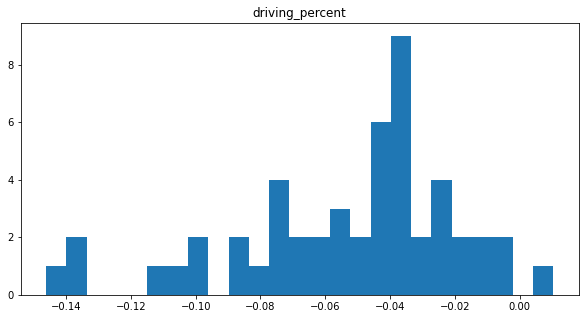

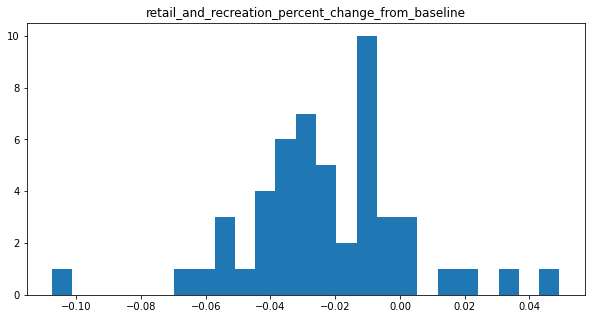

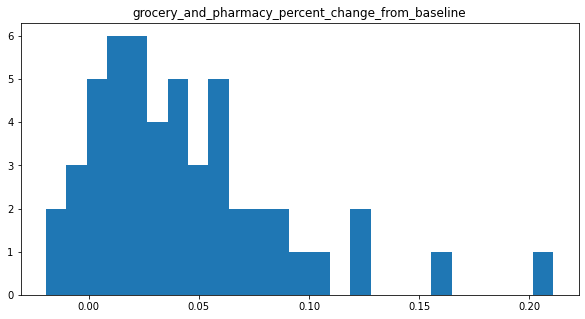

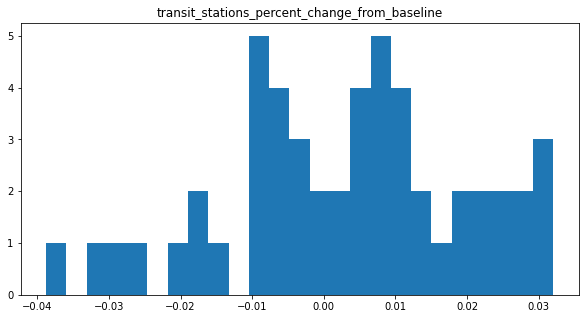

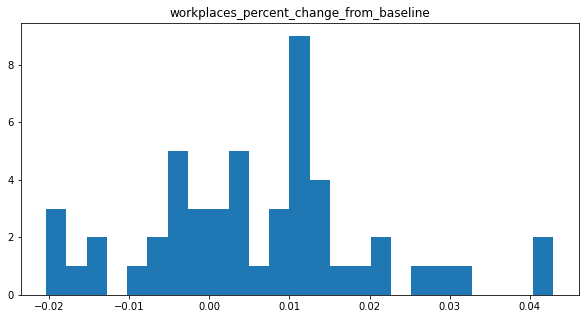

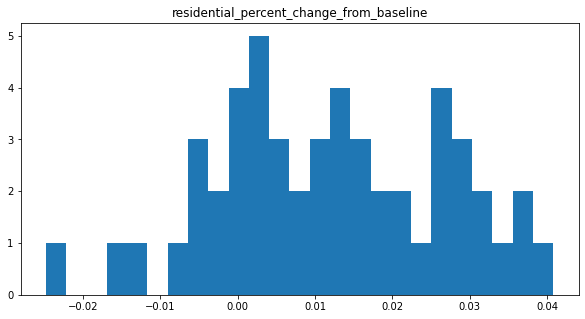

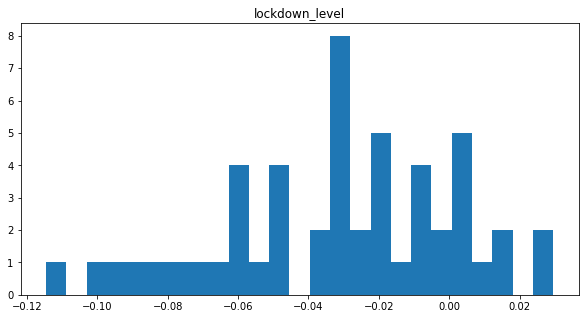

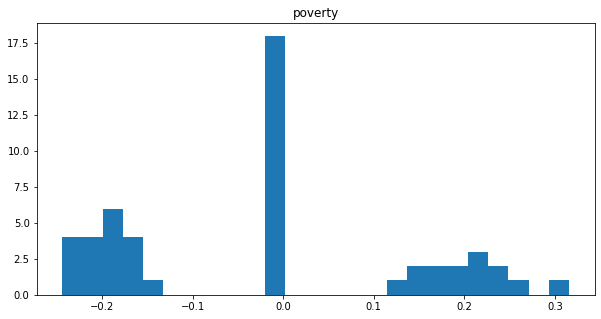

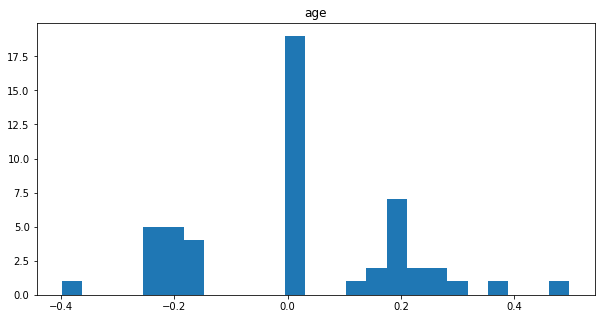

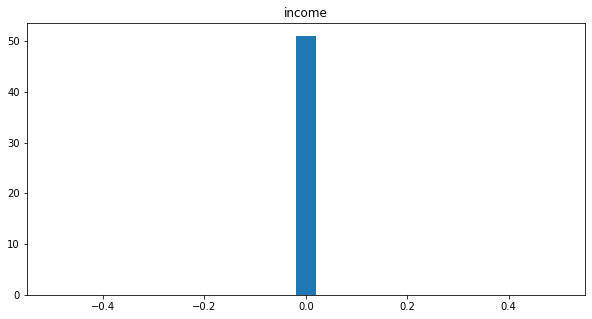

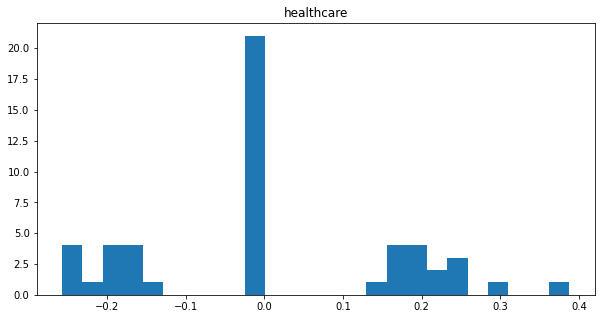

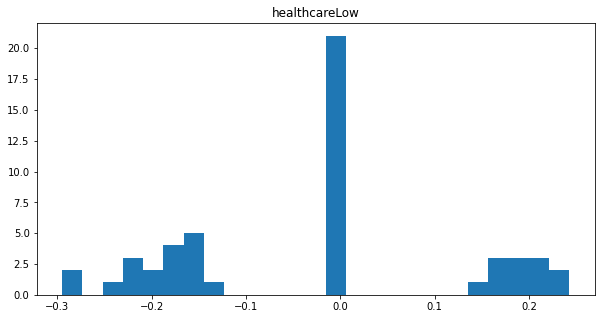

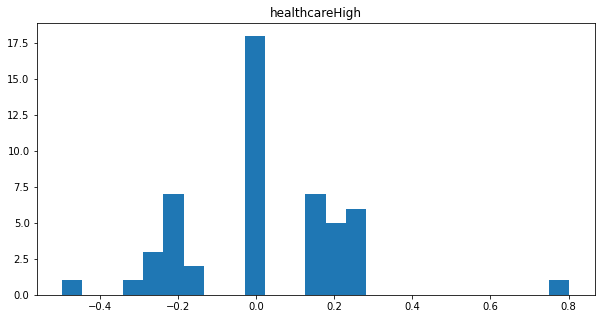

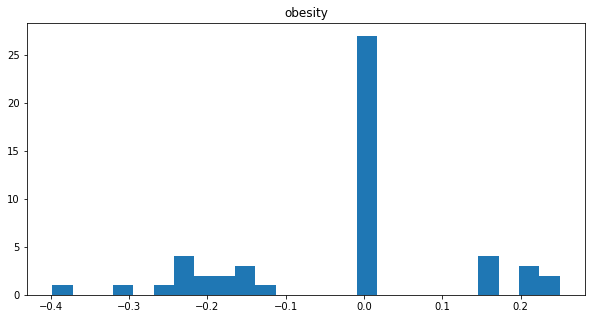

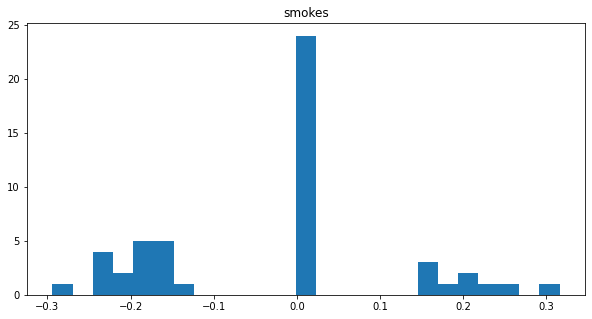

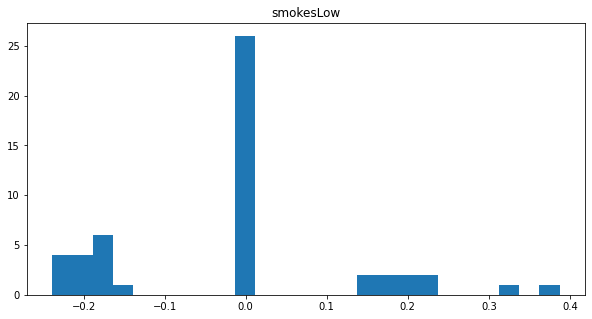

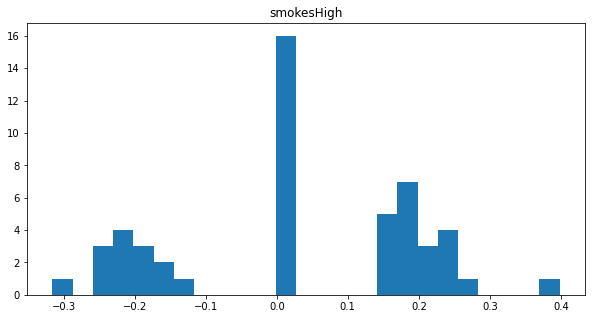

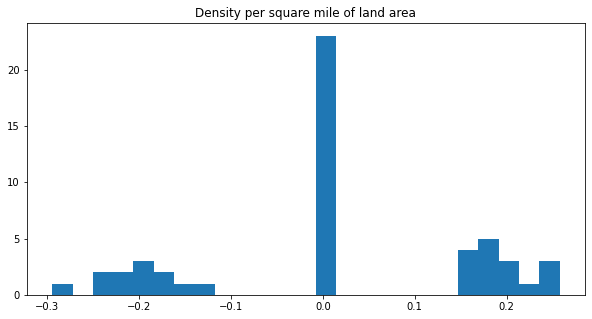

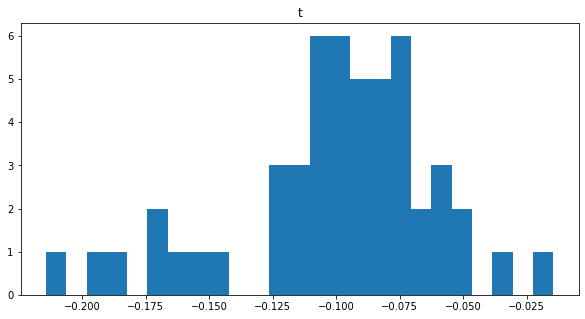

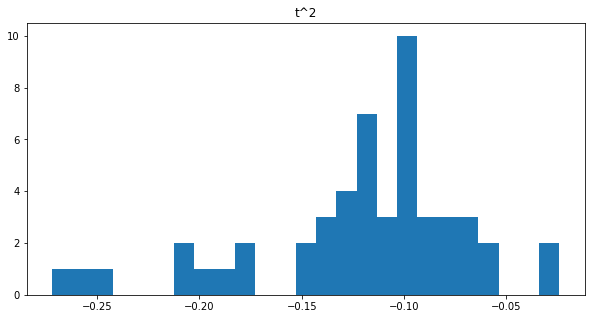

In [9]:

for i, param in enumerate(params + ['t', 't^2']):
    plt.figure(figsize=(10,5))
    plt.hist(regression_coefs[param], bins=25)
    plt.title(param)
    plt.show()

    prev_hidden                              ----------> |i2o| ---------------> output
        +        -----> |input2hidden1| -----|
      input                                  ----------> |input2hidden2|------> hidden

In [0]:

import torch.nn.functional as F
class LSTM(nn.Module):
    # adapted from https://www.jessicayung.com/lstms-for-time-series-in-pytorch/
    def __init__(self, input_dim, hidden_dim1, seq_len=14, output_dim = 1, num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim1 = hidden_dim1
        self.output_dim = output_dim
        self.seq_len = seq_len

        self.num_layers = num_layers

        # define LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim1, self.num_layers)

        # define output layer
        self.linear1 = nn.Linear(self.hidden_dim1, self.output_dim)
        #self.linear2 = nn.Linear(self.hidden_dim2, self.output_dim)

    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.seq_len, self.hidden_dim1),
                torch.zeros(self.num_layers, self.seq_len, self.hidden_dim1))
    
    def forward(self, input):
        # lstm_out shape: [input_size, batch_size, hidden_dim]
        # self.hidden shape: (a, b)
        # where a and b both have shape (num_layers, batch_size, hidden_dim)
        #print(input.shape)
        lstm_out, self.hidden = self.lstm(
            input.reshape(len(input), self.seq_len, -1))
        y_pred = self.linear1(lstm_out.view(self.seq_len, len(input), -1)[-1])
        return y_pred.reshape((-1, self.output_dim))


def sliding_windows(X, Y, seq_length):
    xs = []
    ys = []
    for i in range(len(X) - seq_length - 1):
        x = X[i:(i+seq_length)]
        y = Y[i+seq_length]
        xs.append(x)
        ys.append(y)
    return torch.from_numpy(np.array(xs)), torch.from_numpy(np.array(ys))




starting Delaware
22
Epoch  0 MSE:  0.705196738243103


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch  500 MSE:  0.00011932542838621885
Epoch  1000 MSE:  4.541972521110438e-05
Epoch  1500 MSE:  3.12026750179939e-05


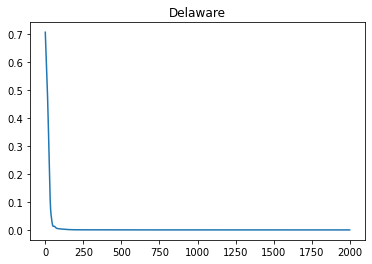

prediction vs actual:
[(tensor([1.5782, 0.0927]), array([1.59      , 0.08396076])),
 (tensor([1.5706, 0.0959]), array([1.64      , 0.07924985])),
 (tensor([1.5555, 0.0990]), array([1.6       , 0.08264463])),
 (tensor([1.5223, 0.1032]), array([1.57     , 0.0916963])),
 (tensor([1.4954, 0.1087]), array([1.58      , 0.09622534])),
 (tensor([1.4647, 0.1158]), array([1.56      , 0.09622534])),
 (tensor([1.4393, 0.1230]), array([1.52     , 0.1084619])),
 (tensor([1.4079, 0.1307]), array([1.49     , 0.1084619])),
 (tensor([1.3912, 0.1364]), array([1.47      , 0.12204247])),
 (tensor([1.3662, 0.1374]), array([1.43      , 0.11293757])),
 (tensor([1.3288, 0.1444]), array([1.41      , 0.13320724])),
 (tensor([1.3055, 0.1510]), array([1.4       , 0.13320724])),
 (tensor([1.2908, 0.1556]), array([1.36      , 0.13747885])),
 (tensor([1.2787, 0.1609]), array([1.33      , 0.14312419])),
 (tensor([1.2619, 0.1666]), array([1.3       , 0.15371699])),
 (tensor([1.2580, 0.1701]), array([1.3       , 0.15543

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch  500 MSE:  0.00012535146379377693
Epoch  1000 MSE:  3.42913372151088e-05
Epoch  1500 MSE:  1.9972443624283187e-05


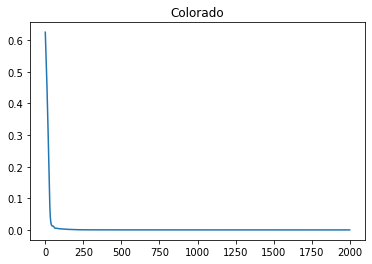

prediction vs actual:
[(tensor([1.4885, 0.1789]), array([1.54      , 0.17603419])),
 (tensor([1.4441, 0.1834]), array([1.49      , 0.17924377])),
 (tensor([1.3967, 0.1880]), array([1.44      , 0.18264661])),
 (tensor([1.3593, 0.1912]), array([1.4       , 0.18907163])),
 (tensor([1.3291, 0.1920]), array([1.36      , 0.19100418])),
 (tensor([1.2958, 0.1927]), array([1.33      , 0.19206146])),
 (tensor([1.2654, 0.1938]), array([1.29      , 0.19244651])),
 (tensor([1.2406, 0.1954]), array([1.27      , 0.19324411])),
 (tensor([1.2198, 0.1971]), array([1.24      , 0.19367102])),
 (tensor([1.2020, 0.1990]), array([1.22      , 0.19936912])),
 (tensor([1.1983, 0.1992]), array([1.2       , 0.19936912])),
 (tensor([1.1845, 0.1986]), array([1.2       , 0.19766008])),
 (tensor([1.1897, 0.2022]), array([1.18      , 0.20472105])),
 (tensor([1.1962, 0.2039]), array([1.2      , 0.1985184])),
 (tensor([1.2008, 0.2050]), array([1.2       , 0.20063163])),
 (tensor([1.1920, 0.2054]), array([1.19    , 0.204

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch  500 MSE:  0.00013427695375867188
Epoch  1000 MSE:  9.17047873372212e-05
Epoch  1500 MSE:  7.177323277574033e-05


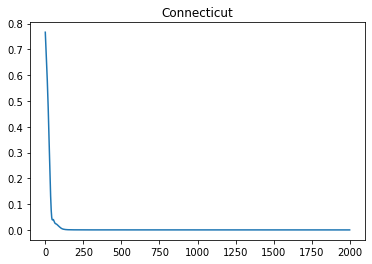

prediction vs actual:
[(tensor([1.7335, 0.2171]), array([1.78      , 0.21427711])),
 (tensor([1.6941, 0.2284]), array([1.74      , 0.20896175])),
 (tensor([1.6438, 0.2419]), array([1.69      , 0.24551586])),
 (tensor([1.6050, 0.2518]), array([1.63      , 0.23950247])),
 (tensor([1.5715, 0.2595]), array([1.62      , 0.24387624])),
 (tensor([1.5208, 0.2683]), array([1.57      , 0.25878738])),
 (tensor([1.4722, 0.2764]), array([1.53      , 0.26797768])),
 (tensor([1.4302, 0.2827]), array([1.46      , 0.26797768])),
 (tensor([1.3946, 0.2871]), array([1.42      , 0.29204227])),
 (tensor([1.3609, 0.2885]), array([1.41      , 0.29039903])),
 (tensor([1.3323, 0.2905]), array([1.36     , 0.2889709])),
 (tensor([1.2941, 0.2977]), array([1.33      , 0.29196992])),
 (tensor([1.2662, 0.3007]), array([1.29      , 0.30199282])),
 (tensor([1.2519, 0.2995]), array([1.27     , 0.3051635])),
 (tensor([1.2334, 0.3006]), array([1.24      , 0.29425842])),
 (tensor([1.2123, 0.3029]), array([1.24      , 0.299

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch  500 MSE:  1.765761771821417e-05
Epoch  1000 MSE:  1.0620929060678463e-05
Epoch  1500 MSE:  8.140772479237057e-06


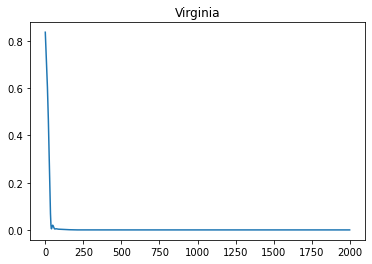

prediction vs actual:
[(tensor([1.5207, 0.1158]), array([1.73      , 0.09671533])),
 (tensor([1.4876, 0.1199]), array([1.68      , 0.09699244])),
 (tensor([1.4548, 0.1233]), array([1.67      , 0.10586688])),
 (tensor([1.4254, 0.1269]), array([1.61      , 0.11168337])),
 (tensor([1.3992, 0.1299]), array([1.6       , 0.11140214])),
 (tensor([1.3640, 0.1360]), array([1.55      , 0.11736879])),
 (tensor([1.3574, 0.1376]), array([1.52      , 0.11635538])),
 (tensor([1.3426, 0.1428]), array([1.49      , 0.11894273])),
 (tensor([1.3257, 0.1475]), array([1.45      , 0.12238842])),
 (tensor([1.3053, 0.1501]), array([1.43      , 0.12716095])),
 (tensor([1.2866, 0.1526]), array([1.4       , 0.13360878])),
 (tensor([1.2717, 0.1539]), array([1.36      , 0.13189946])),
 (tensor([1.2567, 0.1575]), array([1.36      , 0.13881307])),
 (tensor([1.2421, 0.1618]), array([1.34      , 0.14430699])),
 (tensor([1.2325, 0.1632]), array([1.33      , 0.14716204])),
 (tensor([1.2272, 0.1642]), array([1.3       , 0

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch  500 MSE:  7.583078695461154e-05
Epoch  1000 MSE:  4.4842025090474635e-05
Epoch  1500 MSE:  3.016065420524683e-05


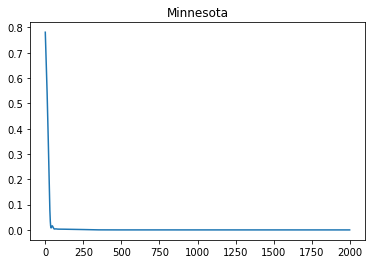

prediction vs actual:
[(tensor([1.4158, 0.0313]), array([1.45     , 0.0325138])),
 (tensor([1.4074, 0.0320]), array([1.42      , 0.03313388])),
 (tensor([1.3939, 0.0329]), array([1.41      , 0.03256697])),
 (tensor([1.3816, 0.0363]), array([1.39      , 0.03402431])),
 (tensor([1.3735, 0.0382]), array([1.37      , 0.03491803])),
 (tensor([1.3603, 0.0374]), array([1.38      , 0.03505404])),
 (tensor([1.3475, 0.0375]), array([1.36      , 0.03653452])),
 (tensor([1.3334, 0.0378]), array([1.35      , 0.03752479])),
 (tensor([1.3182, 0.0388]), array([1.33      , 0.03845916])),
 (tensor([1.3043, 0.0387]), array([1.32      , 0.03941701])),
 (tensor([1.2935, 0.0410]), array([1.31      , 0.04030618])),
 (tensor([1.2809, 0.0439]), array([1.29      , 0.04331792])),
 (tensor([1.2732, 0.0466]), array([1.28      , 0.04293856])),
 (tensor([1.2669, 0.0463]), array([1.28      , 0.04319462])),
 (tensor([1.2676, 0.0466]), array([1.27      , 0.04495303])),
 (tensor([1.2708, 0.0470]), array([1.25      , 0.0

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch  500 MSE:  5.5410149798262864e-05
Epoch  1000 MSE:  3.070502862101421e-05
Epoch  1500 MSE:  2.3787852114764974e-05


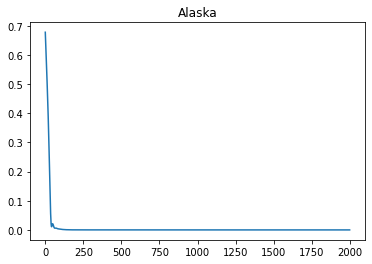

prediction vs actual:
[(tensor([1.3796, 0.0263]), array([1.42     , 0.0288942])),
 (tensor([1.3762, 0.0270]), array([1.38      , 0.02847471])),
 (tensor([1.3633, 0.0278]), array([1.38      , 0.02609707])),
 (tensor([1.3443, 0.0303]), array([1.36      , 0.02831126])),
 (tensor([1.3192, 0.0311]), array([1.34      , 0.02943985])),
 (tensor([1.2954, 0.0291]), array([1.32      , 0.02774953])),
 (tensor([1.2733, 0.0313]), array([1.3       , 0.03081151])),
 (tensor([1.2512, 0.0328]), array([1.28     , 0.0319751])),
 (tensor([1.2289, 0.0339]), array([1.24      , 0.03253496])),
 (tensor([1.2072, 0.0340]), array([1.22      , 0.03310011])),
 (tensor([1.1821, 0.0322]), array([1.22      , 0.03323849])),
 (tensor([1.1698, 0.0358]), array([1.18      , 0.03383926])),
 (tensor([1.1473, 0.0339]), array([1.18      , 0.03537676])),
 (tensor([1.1303, 0.0351]), array([1.14      , 0.03413991])),
 (tensor([1.1117, 0.0333]), array([1.12     , 0.0338181])),
 (tensor([1.0959, 0.0328]), array([1.12      , 0.03434

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch  500 MSE:  6.061225212761201e-05
Epoch  1000 MSE:  4.0291746699949726e-05
Epoch  1500 MSE:  3.1381805456476286e-05


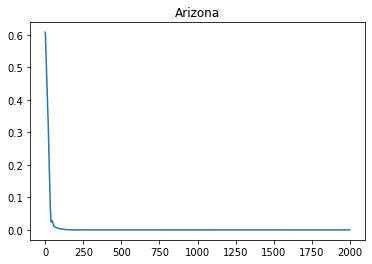

prediction vs actual:
[(tensor([1.5173, 0.0697]), array([1.58      , 0.06710039])),
 (tensor([1.4723, 0.0729]), array([1.52      , 0.07036858])),
 (tensor([1.4242, 0.0757]), array([1.47      , 0.07169781])),
 (tensor([1.3889, 0.0772]), array([1.42      , 0.07433726])),
 (tensor([1.3610, 0.0780]), array([1.39      , 0.08278001])),
 (tensor([1.3266, 0.0796]), array([1.37      , 0.07549026])),
 (tensor([1.3020, 0.0802]), array([1.33      , 0.07715356])),
 (tensor([1.2827, 0.0808]), array([1.29      , 0.07886819])),
 (tensor([1.2654, 0.0816]), array([1.27      , 0.08117704])),
 (tensor([1.2482, 0.0828]), array([1.27      , 0.08247204])),
 (tensor([1.2358, 0.0844]), array([1.26      , 0.08371577])),
 (tensor([1.2308, 0.0853]), array([1.24      , 0.08404379])),
 (tensor([1.2128, 0.0861]), array([1.23      , 0.08540383])),
 (tensor([1.2024, 0.0868]), array([1.21      , 0.08631168])),
 (tensor([1.1920, 0.0879]), array([1.2       , 0.08744207])),
 (tensor([1.1853, 0.0897]), array([1.19      , 0

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch  500 MSE:  0.00015323875413741916
Epoch  1000 MSE:  2.3394275558530353e-05
Epoch  1500 MSE:  9.636128197598737e-06


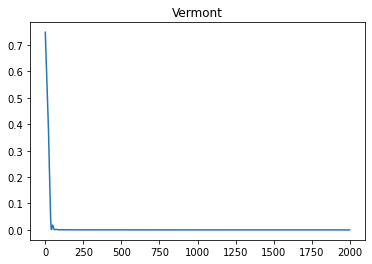

prediction vs actual:
[(tensor([1.1801, 0.0739]), array([1.41      , 0.07141268])),
 (tensor([1.1685, 0.0711]), array([1.39      , 0.06694395])),
 (tensor([1.1427, 0.0730]), array([1.39      , 0.07440704])),
 (tensor([1.1316, 0.0687]), array([1.37      , 0.07888433])),
 (tensor([1.1198, 0.0661]), array([1.35      , 0.07778791])),
 (tensor([1.1056, 0.0648]), array([1.32      , 0.08186341])),
 (tensor([1.0935, 0.0636]), array([1.3       , 0.08065647])),
 (tensor([1.0848, 0.0633]), array([1.28      , 0.07807459])),
 (tensor([1.0827, 0.0630]), array([1.26      , 0.07676323])),
 (tensor([1.0800, 0.0607]), array([1.23      , 0.08248299])),
 (tensor([1.0759, 0.0600]), array([1.2       , 0.07679844])),
 (tensor([1.0738, 0.0594]), array([1.18      , 0.07387461])),
 (tensor([1.0725, 0.0589]), array([1.17      , 0.07215898])),
 (tensor([1.0649, 0.0586]), array([1.14      , 0.07104393])),
 (tensor([1.0568, 0.0575]), array([1.13      , 0.06849562])),
 (tensor([1.0571, 0.0581]), array([1.12      , 0

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch  500 MSE:  5.979686466162093e-05
Epoch  1000 MSE:  2.231107464467641e-05
Epoch  1500 MSE:  1.9017033991985954e-05


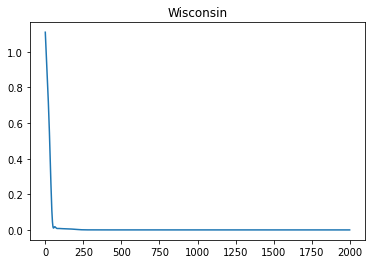

prediction vs actual:
[(tensor([1.5453, 0.0788]), array([1.59      , 0.07609603])),
 (tensor([1.5017, 0.0793]), array([1.55      , 0.07846873])),
 (tensor([1.4501, 0.0806]), array([1.49      , 0.07871876])),
 (tensor([1.4167, 0.0822]), array([1.46      , 0.08132147])),
 (tensor([1.3889, 0.0833]), array([1.41      , 0.08262866])),
 (tensor([1.3557, 0.0841]), array([1.4       , 0.08409733])),
 (tensor([1.3204, 0.0844]), array([1.35      , 0.08292055])),
 (tensor([1.2855, 0.0839]), array([1.32     , 0.0838429])),
 (tensor([1.2572, 0.0842]), array([1.28      , 0.08408872])),
 (tensor([1.2353, 0.0841]), array([1.26      , 0.08453421])),
 (tensor([1.2028, 0.0858]), array([1.24      , 0.08479139])),
 (tensor([1.1843, 0.0826]), array([1.2       , 0.08510584])),
 (tensor([1.1724, 0.0868]), array([1.18   , 0.08528])),
 (tensor([1.1620, 0.0875]), array([1.18      , 0.08555545])),
 (tensor([1.1509, 0.0881]), array([1.16     , 0.0864404])),
 (tensor([1.1454, 0.0876]), array([1.15      , 0.08640103]

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch  500 MSE:  0.00010116164048667997
Epoch  1000 MSE:  7.329639629460871e-05
Epoch  1500 MSE:  4.7949601139407605e-05


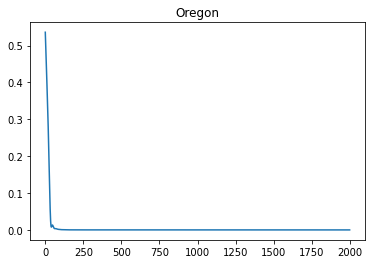

prediction vs actual:
[(tensor([1.2968, 0.0555]), array([1.38      , 0.05305652])),
 (tensor([1.2745, 0.0543]), array([1.35      , 0.05135219])),
 (tensor([1.2572, 0.0517]), array([1.32      , 0.05156591])),
 (tensor([1.2386, 0.0508]), array([1.3       , 0.05697502])),
 (tensor([1.2165, 0.0502]), array([1.27      , 0.05178433])),
 (tensor([1.1943, 0.0500]), array([1.26      , 0.05192422])),
 (tensor([1.1718, 0.0500]), array([1.23     , 0.0513322])),
 (tensor([1.1518, 0.0510]), array([1.22      , 0.05043967])),
 (tensor([1.1419, 0.0530]), array([1.21     , 0.0515472])),
 (tensor([1.1212, 0.0520]), array([1.16     , 0.0515472])),
 (tensor([1.1179, 0.0512]), array([1.15      , 0.05035998])),
 (tensor([1.1142, 0.0512]), array([1.14      , 0.05131393])),
 (tensor([1.1112, 0.0510]), array([1.12      , 0.05089811])),
 (tensor([1.1052, 0.0507]), array([1.12      , 0.05045886])),
 (tensor([1.0992, 0.0497]), array([1.11      , 0.04986357])),
 (tensor([1.0895, 0.0492]), array([1.11      , 0.04968

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch  500 MSE:  0.0007846454973332584
Epoch  1000 MSE:  3.6225806979928166e-05
Epoch  1500 MSE:  1.8342436305829324e-05


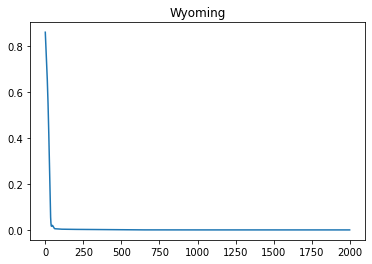

prediction vs actual:
[(tensor([1.2615, 0.0525]), array([1.48      , 0.05536627])),
 (tensor([1.2383, 0.0511]), array([1.48      , 0.05793743])),
 (tensor([1.2161, 0.0493]), array([1.42      , 0.05652477])),
 (tensor([1.1864, 0.0502]), array([1.4       , 0.05970626])),
 (tensor([1.1615, 0.0472]), array([1.36      , 0.06085882])),
 (tensor([1.1284, 0.0458]), array([1.34      , 0.05344871])),
 (tensor([1.1051, 0.0451]), array([1.32      , 0.05393258])),
 (tensor([1.0857, 0.0445]), array([1.26      , 0.05437992])),
 (tensor([1.0624, 0.0441]), array([1.26      , 0.05542169])),
 (tensor([1.0584, 0.0438]), array([1.24      , 0.05071157])),
 (tensor([1.0576, 0.0420]), array([1.22      , 0.04781095])),
 (tensor([1.0572, 0.0421]), array([1.18      , 0.04781095])),
 (tensor([1.0651, 0.0433]), array([1.16      , 0.04610999])),
 (tensor([1.0751, 0.0446]), array([1.14      , 0.04610999])),
 (tensor([1.0804, 0.0451]), array([1.1       , 0.04534682])),
 (tensor([1.0805, 0.0449]), array([1.08     , 0.

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch  500 MSE:  0.00023037406208459288
Epoch  1000 MSE:  0.00011957262904616073
Epoch  1500 MSE:  7.185731374192983e-05


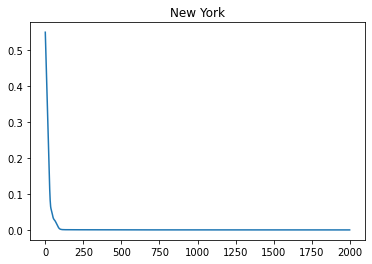

prediction vs actual:
[(tensor([1.4994, 0.3866]), array([1.57      , 0.37899312])),
 (tensor([1.4541, 0.3937]), array([1.5       , 0.38658799])),
 (tensor([1.3944, 0.4017]), array([1.45      , 0.39483725])),
 (tensor([1.3125, 0.4051]), array([1.4      , 0.4009012])),
 (tensor([1.2406, 0.4057]), array([1.31      , 0.40370187])),
 (tensor([1.2036, 0.4085]), array([1.25      , 0.40737069])),
 (tensor([1.1718, 0.4091]), array([1.18      , 0.40835093])),
 (tensor([1.1357, 0.4082]), array([1.18      , 0.40891352])),
 (tensor([1.0876, 0.4083]), array([1.15     , 0.4084725])),
 (tensor([1.0232, 0.4090]), array([1.08     , 0.4080357])),
 (tensor([0.9641, 0.4101]), array([1.02      , 0.40922037])),
 (tensor([0.9135, 0.4061]), array([0.97      , 0.40878161])),
 (tensor([0.8718, 0.4065]), array([0.9       , 0.40771014])),
 (tensor([0.8445, 0.4061]), array([0.89      , 0.40511036])),
 (tensor([0.8287, 0.4035]), array([0.84      , 0.40641468])),
 (tensor([0.8215, 0.4010]), array([0.83      , 0.40372

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch  500 MSE:  0.00018842970894183964
Epoch  1000 MSE:  0.00011388787970645353
Epoch  1500 MSE:  8.782064105616882e-05


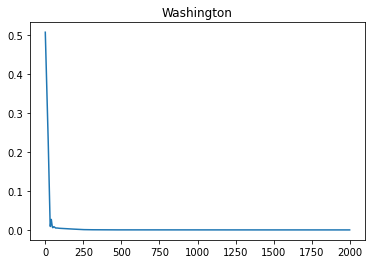

prediction vs actual:
[(tensor([1.1950, 0.0736]), array([1.22      , 0.07340314])),
 (tensor([1.1709, 0.0754]), array([1.19      , 0.07350025])),
 (tensor([1.1411, 0.0769]), array([1.18      , 0.07528801])),
 (tensor([1.1062, 0.0773]), array([1.14     , 0.0769041])),
 (tensor([1.0762, 0.0774]), array([1.1       , 0.07906869])),
 (tensor([1.0435, 0.0776]), array([1.08      , 0.07865449])),
 (tensor([1.0149, 0.0783]), array([1.05      , 0.07814237])),
 (tensor([0.9852, 0.0781]), array([1.02     , 0.0780444])),
 (tensor([0.9580, 0.0784]), array([0.97      , 0.07778033])),
 (tensor([0.9329, 0.0791]), array([0.95      , 0.07868637])),
 (tensor([0.9092, 0.0791]), array([0.94      , 0.07914453])),
 (tensor([0.8892, 0.0800]), array([0.93      , 0.08002709])),
 (tensor([0.8750, 0.0786]), array([0.89      , 0.07908537])),
 (tensor([0.8647, 0.0770]), array([0.86      , 0.07823899])),
 (tensor([0.8528, 0.0756]), array([0.86      , 0.07820867])),
 (tensor([0.8447, 0.0762]), array([0.87      , 0.077

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch  500 MSE:  0.000704342732205987
Epoch  1000 MSE:  0.00027755129849538207
Epoch  1500 MSE:  8.109304326353595e-05


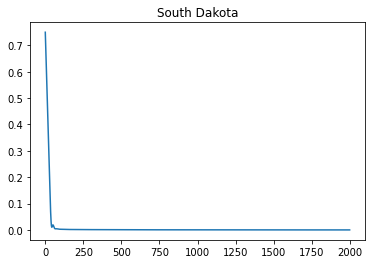

prediction vs actual:
[(tensor([1.1783, 0.1382]), array([1.74      , 0.03199405])),
 (tensor([1.1461, 0.1367]), array([1.78      , 0.03765404])),
 (tensor([1.0927, 0.1379]), array([1.74      , 0.03912134])),
 (tensor([1.0847, 0.1400]), array([1.76      , 0.04058193])),
 (tensor([1.2766, 0.1364]), array([1.78      , 0.04291078])),
 (tensor([1.2538, 0.1368]), array([1.78      , 0.04784053])),
 (tensor([1.2269, 0.1369]), array([1.78      , 0.05105297])),
 (tensor([1.2315, 0.1392]), array([1.78      , 0.05823948])),
 (tensor([1.2195, 0.1407]), array([1.78      , 0.06254372]))]
starting Nebraska
22
Epoch  0 MSE:  0.7550100684165955


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch  500 MSE:  9.351602056995034e-05
Epoch  1000 MSE:  4.561799141811207e-05
Epoch  1500 MSE:  2.471060724928975e-05


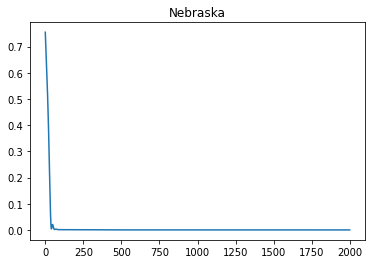

prediction vs actual:
[(tensor([1.4696, 0.0746]), array([1.57      , 0.05698779])),
 (tensor([1.3929, 0.0750]), array([1.56      , 0.05823864])),
 (tensor([1.4345, 0.0772]), array([1.53      , 0.05853966])),
 (tensor([1.4211, 0.0779]), array([1.52      , 0.05967652])),
 (tensor([1.4341, 0.0806]), array([1.5       , 0.06130721])),
 (tensor([1.4264, 0.0841]), array([1.47      , 0.06026227])),
 (tensor([1.4431, 0.0899]), array([1.46      , 0.06158721])),
 (tensor([1.4926, 0.0934]), array([1.44      , 0.06519281])),
 (tensor([1.4785, 0.0984]), array([1.43      , 0.06530001])),
 (tensor([1.4582, 0.1038]), array([1.41     , 0.0678854])),
 (tensor([1.4316, 0.1081]), array([1.41      , 0.07010516])),
 (tensor([1.4197, 0.1144]), array([1.41      , 0.07398747])),
 (tensor([1.4208, 0.1194]), array([1.47      , 0.07418884])),
 (tensor([1.4042, 0.1263]), array([1.39      , 0.07669279])),
 (tensor([1.3839, 0.1366]), array([1.44      , 0.07681814])),
 (tensor([1.3662, 0.1399]), array([1.42      , 0.0

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch  500 MSE:  9.19794401852414e-05
Epoch  1000 MSE:  4.6710069000255316e-05
Epoch  1500 MSE:  2.849519660230726e-05


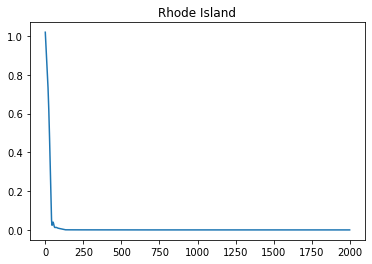

prediction vs actual:
[(tensor([1.5921, 0.1382]), array([1.7       , 0.12872413])),
 (tensor([1.5555, 0.1326]), array([1.72      , 0.12961136])),
 (tensor([1.5161, 0.1317]), array([1.72      , 0.12738052])),
 (tensor([1.4828, 0.1430]), array([1.67      , 0.12613459])),
 (tensor([1.4484, 0.1416]), array([1.74      , 0.12839437])),
 (tensor([1.4518, 0.1370]), array([1.68      , 0.12757929])),
 (tensor([1.4360, 0.1361]), array([1.67      , 0.11933637])),
 (tensor([1.4169, 0.1355]), array([1.64      , 0.11951863])),
 (tensor([1.3729, 0.1359]), array([1.6       , 0.13917318])),
 (tensor([1.3231, 0.1391]), array([1.59      , 0.14094852])),
 (tensor([1.2858, 0.1379]), array([1.56      , 0.12901631])),
 (tensor([1.2607, 0.1381]), array([1.51      , 0.13095823])),
 (tensor([1.2508, 0.1390]), array([1.49      , 0.14403949])),
 (tensor([1.2498, 0.1400]), array([1.44      , 0.14196507])),
 (tensor([1.2401, 0.1396]), array([1.45      , 0.13627061])),
 (tensor([1.2274, 0.1397]), array([1.45      , 0

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch  500 MSE:  7.20117604942061e-05
Epoch  1000 MSE:  4.145861021243036e-05
Epoch  1500 MSE:  2.828758988471236e-05


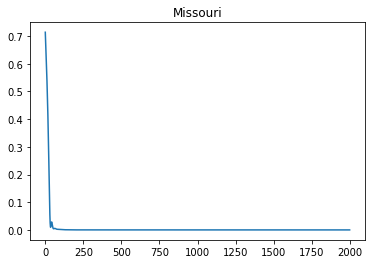

prediction vs actual:
[(tensor([1.2884, 0.0926]), array([1.6       , 0.09072129])),
 (tensor([1.2462, 0.0917]), array([1.55      , 0.09317685])),
 (tensor([1.2126, 0.0928]), array([1.51      , 0.09841639])),
 (tensor([1.1830, 0.0931]), array([1.45      , 0.09198956])),
 (tensor([1.1797, 0.0954]), array([1.4       , 0.08686557])),
 (tensor([1.1730, 0.1000]), array([1.39      , 0.09123513])),
 (tensor([1.1499, 0.1003]), array([1.34      , 0.09499828])),
 (tensor([1.1230, 0.1021]), array([1.3       , 0.09753738])),
 (tensor([1.1029, 0.1017]), array([1.29      , 0.09193641])),
 (tensor([1.0994, 0.1024]), array([1.24      , 0.09324988])),
 (tensor([1.1030, 0.1036]), array([1.22      , 0.09320856])),
 (tensor([1.0883, 0.1034]), array([1.18     , 0.0920354])),
 (tensor([1.0700, 0.1046]), array([1.18      , 0.09659241])),
 (tensor([1.0622, 0.1041]), array([1.18      , 0.09766977])),
 (tensor([1.0562, 0.1029]), array([1.14     , 0.0998735])),
 (tensor([1.0529, 0.1018]), array([1.12      , 0.100

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch  500 MSE:  0.00011663814802886918
Epoch  1000 MSE:  7.943248056108132e-05
Epoch  1500 MSE:  4.7984038246795535e-05


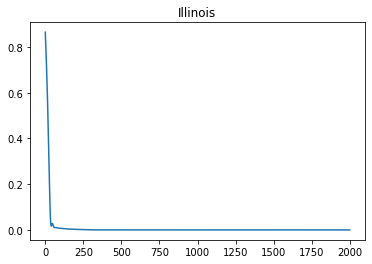

prediction vs actual:
[(tensor([1.6001, 0.1787]), array([1.66      , 0.17284073])),
 (tensor([1.5663, 0.1850]), array([1.61      , 0.17626443])),
 (tensor([1.5283, 0.1894]), array([1.56      , 0.18531469])),
 (tensor([1.4854, 0.1925]), array([1.53      , 0.19329613])),
 (tensor([1.4453, 0.1945]), array([1.47      , 0.19083465])),
 (tensor([1.4102, 0.1975]), array([1.45      , 0.19481427])),
 (tensor([1.3707, 0.2001]), array([1.42      , 0.19712798])),
 (tensor([1.3339, 0.2032]), array([1.37      , 0.20086324])),
 (tensor([1.3001, 0.2060]), array([1.33     , 0.2030993])),
 (tensor([1.2697, 0.2079]), array([1.3      , 0.2043598])),
 (tensor([1.2397, 0.2086]), array([1.27      , 0.20814116])),
 (tensor([1.2211, 0.2070]), array([1.24      , 0.20699856])),
 (tensor([1.1966, 0.2082]), array([1.22      , 0.20823879])),
 (tensor([1.1802, 0.2101]), array([1.2       , 0.21015947])),
 (tensor([1.1703, 0.2118]), array([1.18      , 0.21032421])),
 (tensor([1.1685, 0.2138]), array([1.17     , 0.2099

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch  500 MSE:  6.314064376056194e-05
Epoch  1000 MSE:  3.890271545969881e-05
Epoch  1500 MSE:  2.77166000159923e-05


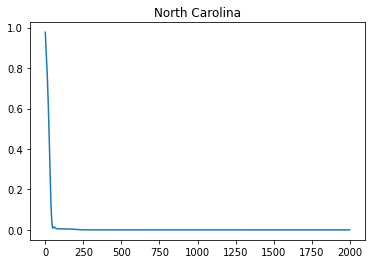

prediction vs actual:
[(tensor([1.4596, 0.0625]), array([1.59      , 0.06035895])),
 (tensor([1.4484, 0.0672]), array([1.53      , 0.06475121])),
 (tensor([1.4293, 0.0721]), array([1.51      , 0.06623837])),
 (tensor([1.3992, 0.0739]), array([1.46      , 0.06195033])),
 (tensor([1.3718, 0.0749]), array([1.45      , 0.06455238])),
 (tensor([1.3417, 0.0757]), array([1.42      , 0.07047095])),
 (tensor([1.3198, 0.0745]), array([1.41      , 0.07840417])),
 (tensor([1.3102, 0.0694]), array([1.37      , 0.07969851])),
 (tensor([1.2839, 0.0739]), array([1.34      , 0.07636637])),
 (tensor([1.2651, 0.0777]), array([1.32      , 0.06779426])),
 (tensor([1.2386, 0.0766]), array([1.31    , 0.071399])),
 (tensor([1.2204, 0.0766]), array([1.28      , 0.07274015])),
 (tensor([1.2102, 0.0768]), array([1.27      , 0.07597653])),
 (tensor([1.2056, 0.0775]), array([1.24      , 0.07724596])),
 (tensor([1.2017, 0.0782]), array([1.22      , 0.07553039])),
 (tensor([1.1907, 0.0812]), array([1.21      , 0.077

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch  500 MSE:  5.376604531193152e-05
Epoch  1000 MSE:  4.3170948629267514e-05
Epoch  1500 MSE:  3.550454493961297e-05


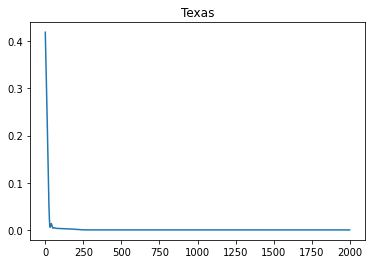

prediction vs actual:
[(tensor([1.2255, 0.0940]), array([1.44      , 0.08351965])),
 (tensor([1.1961, 0.0995]), array([1.41      , 0.09212889])),
 (tensor([1.1692, 0.1029]), array([1.39      , 0.09558138])),
 (tensor([1.1422, 0.1049]), array([1.36      , 0.09584163])),
 (tensor([1.1159, 0.1056]), array([1.33      , 0.09602752])),
 (tensor([1.0979, 0.1034]), array([1.29      , 0.08524198])),
 (tensor([1.0651, 0.1021]), array([1.26      , 0.09319902])),
 (tensor([1.0295, 0.1019]), array([1.23      , 0.09716595])),
 (tensor([0.9979, 0.1019]), array([1.19      , 0.09638759])),
 (tensor([0.9835, 0.1025]), array([1.17      , 0.10085726])),
 (tensor([0.9793, 0.1030]), array([1.14      , 0.10421212])),
 (tensor([0.9772, 0.1044]), array([1.12      , 0.10827652])),
 (tensor([0.9837, 0.1029]), array([1.09      , 0.10437903])),
 (tensor([1.0091, 0.0996]), array([1.08      , 0.09984502])),
 (tensor([1.0281, 0.0973]), array([1.02      , 0.10204861])),
 (tensor([1.0435, 0.0958]), array([1.        , 0

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch  500 MSE:  0.00014192622620612383
Epoch  1000 MSE:  7.191055192379281e-05
Epoch  1500 MSE:  5.142592272022739e-05


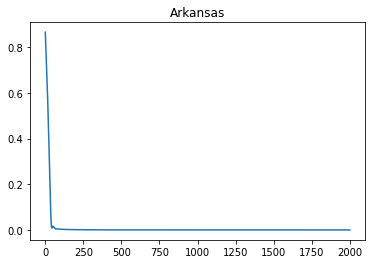

prediction vs actual:
[(tensor([1.4202, 0.0762]), array([1.36      , 0.07357017])),
 (tensor([1.4145, 0.0738]), array([1.42      , 0.07544292])),
 (tensor([1.3994, 0.0705]), array([1.42     , 0.0725848])),
 (tensor([1.3855, 0.0685]), array([1.39      , 0.07164899])),
 (tensor([1.3742, 0.0693]), array([1.39      , 0.07383028])),
 (tensor([1.3631, 0.0728]), array([1.37      , 0.06811989])),
 (tensor([1.3418, 0.0715]), array([1.37      , 0.06936501])),
 (tensor([1.3215, 0.0702]), array([1.34      , 0.06882312])),
 (tensor([1.3036, 0.0695]), array([1.32      , 0.07484449])),
 (tensor([1.2821, 0.0674]), array([1.3       , 0.06839953])),
 (tensor([1.2724, 0.0655]), array([1.29      , 0.06599203])),
 (tensor([1.2452, 0.0673]), array([1.27      , 0.06490214])),
 (tensor([1.2408, 0.0705]), array([1.24      , 0.06777543])),
 (tensor([1.2488, 0.0708]), array([1.24      , 0.07003928])),
 (tensor([1.2584, 0.0719]), array([1.25     , 0.0718604])),
 (tensor([1.2641, 0.0718]), array([1.26      , 0.071

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch  500 MSE:  0.00032015994656831026
Epoch  1000 MSE:  0.00013103582023177296
Epoch  1500 MSE:  7.454417209373787e-05


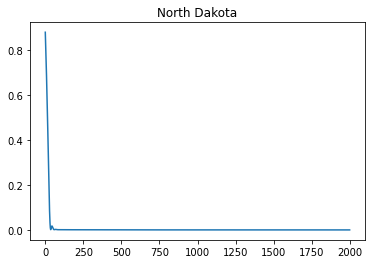

prediction vs actual:
[(tensor([1.3437, 0.0291]), array([1.5       , 0.03160472])),
 (tensor([1.3217, 0.0299]), array([1.48      , 0.03192771])),
 (tensor([1.3003, 0.0301]), array([1.44      , 0.02983788])),
 (tensor([1.2966, 0.0299]), array([1.4       , 0.02996617])),
 (tensor([1.2963, 0.0293]), array([1.38      , 0.03049948])),
 (tensor([1.2930, 0.0293]), array([1.34      , 0.03119368])),
 (tensor([1.3288, 0.0305]), array([1.34      , 0.03076723])),
 (tensor([1.4229, 0.0315]), array([1.3       , 0.02934986])),
 (tensor([1.4321, 0.0302]), array([1.28      , 0.02992214])),
 (tensor([1.4373, 0.0319]), array([1.28      , 0.02893422])),
 (tensor([1.4078, 0.0353]), array([1.3       , 0.02906746])),
 (tensor([1.3962, 0.0376]), array([1.34      , 0.02975845])),
 (tensor([1.3865, 0.0403]), array([1.43      , 0.03070216])),
 (tensor([1.3815, 0.0428]), array([1.43      , 0.03123855])),
 (tensor([1.3707, 0.0440]), array([1.42      , 0.03225236])),
 (tensor([1.3575, 0.0433]), array([1.42      , 0

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch  500 MSE:  3.2400741474702954e-05
Epoch  1000 MSE:  2.7093772587249987e-05
Epoch  1500 MSE:  2.4517203200957738e-05


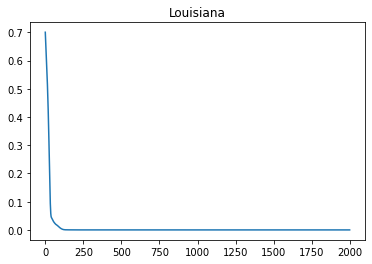

prediction vs actual:
[(tensor([1.6327, 0.1788]), array([1.72      , 0.14033555])),
 (tensor([1.5688, 0.1942]), array([1.63      , 0.17910974])),
 (tensor([1.4937, 0.2095]), array([1.57      , 0.19194706])),
 (tensor([1.4217, 0.2159]), array([1.49      , 0.21361414])),
 (tensor([1.3482, 0.2176]), array([1.42      , 0.21566515])),
 (tensor([1.2777, 0.2143]), array([1.35      , 0.21494665])),
 (tensor([1.2094, 0.2131]), array([1.27      , 0.21812337])),
 (tensor([1.1428, 0.2101]), array([1.21      , 0.20919834])),
 (tensor([1.0750, 0.2084]), array([1.15      , 0.21034526])),
 (tensor([1.0340, 0.2063]), array([1.06      , 0.20863676])),
 (tensor([0.9804, 0.2009]), array([1.04      , 0.20651086])),
 (tensor([0.9706, 0.1889]), array([0.98     , 0.1979432])),
 (tensor([0.9337, 0.1832]), array([0.97      , 0.19442877])),
 (tensor([0.9140, 0.1788]), array([0.93     , 0.1817061])),
 (tensor([0.9018, 0.1767]), array([0.91      , 0.18003248])),
 (tensor([0.8984, 0.1760]), array([0.91      , 0.177

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch  500 MSE:  0.00034717359812930226
Epoch  1000 MSE:  0.00010074488818645477
Epoch  1500 MSE:  5.197556674829684e-05


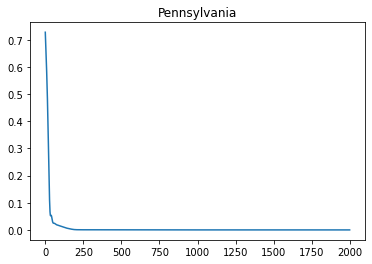

prediction vs actual:
[(tensor([1.6715, 0.1349]), array([1.76      , 0.12035578])),
 (tensor([1.6205, 0.1429]), array([1.72      , 0.12823043])),
 (tensor([1.5621, 0.1498]), array([1.67      , 0.13555502])),
 (tensor([1.5078, 0.1538]), array([1.62     , 0.1430387])),
 (tensor([1.4607, 0.1601]), array([1.57      , 0.14799861])),
 (tensor([1.4043, 0.1655]), array([1.5       , 0.15479285])),
 (tensor([1.3420, 0.1705]), array([1.46      , 0.15950174])),
 (tensor([1.2854, 0.1757]), array([1.41      , 0.16479937])),
 (tensor([1.2342, 0.1820]), array([1.34      , 0.17261037])),
 (tensor([1.1904, 0.1850]), array([1.28      , 0.17677559])),
 (tensor([1.1573, 0.1840]), array([1.24      , 0.18022854])),
 (tensor([1.1198, 0.1894]), array([1.19      , 0.18282489])),
 (tensor([1.0976, 0.1929]), array([1.16      , 0.18644446])),
 (tensor([1.0851, 0.1957]), array([1.11      , 0.18966407])),
 (tensor([1.0783, 0.1989]), array([1.1       , 0.19253692])),
 (tensor([1.0761, 0.2032]), array([1.09      , 0.1

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch  500 MSE:  6.276383646763861e-05
Epoch  1000 MSE:  2.9567414458142594e-05
Epoch  1500 MSE:  2.2229480237001553e-05


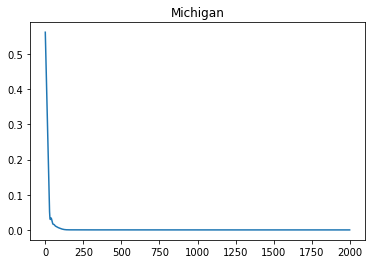

prediction vs actual:
[(tensor([1.5970, 0.3163]), array([1.67      , 0.32119626])),
 (tensor([1.5353, 0.3106]), array([1.6       , 0.31734292])),
 (tensor([1.4673, 0.3077]), array([1.53      , 0.31176158])),
 (tensor([1.4111, 0.3036]), array([1.47      , 0.30473978])),
 (tensor([1.3581, 0.3025]), array([1.41     , 0.3034129])),
 (tensor([1.3028, 0.3080]), array([1.36      , 0.30417944])),
 (tensor([1.2494, 0.3111]), array([1.3       , 0.30322916])),
 (tensor([1.1906, 0.3133]), array([1.25      , 0.31129893])),
 (tensor([1.1433, 0.3151]), array([1.19      , 0.32069675])),
 (tensor([1.1039, 0.3172]), array([1.15     , 0.3162373])),
 (tensor([1.0640, 0.3126]), array([1.1       , 0.31563922])),
 (tensor([1.0565, 0.3103]), array([1.06      , 0.31015774])),
 (tensor([1.0350, 0.3143]), array([1.06      , 0.31018586])),
 (tensor([1.0162, 0.3131]), array([1.04      , 0.31314221])),
 (tensor([0.9978, 0.3099]), array([1.01      , 0.31281983])),
 (tensor([0.9862, 0.3056]), array([0.99      , 0.310

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch  500 MSE:  0.0002001741377171129
Epoch  1000 MSE:  0.00014775358431506902
Epoch  1500 MSE:  0.00010475262388354167


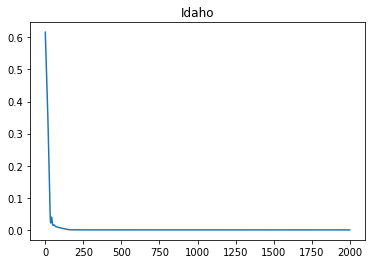

prediction vs actual:
[(tensor([1.4831, 0.0995]), array([1.55     , 0.0795334])),
 (tensor([1.4700, 0.1048]), array([1.49      , 0.09187037])),
 (tensor([1.4420, 0.1078]), array([1.45    , 0.112146])),
 (tensor([1.4032, 0.1074]), array([1.46      , 0.11420519])),
 (tensor([1.3551, 0.1052]), array([1.4       , 0.10496053])),
 (tensor([1.3004, 0.1044]), array([1.35      , 0.10013643])),
 (tensor([1.2397, 0.1034]), array([1.3       , 0.10403699])),
 (tensor([1.1858, 0.1016]), array([1.26      , 0.10169776])),
 (tensor([1.1440, 0.1006]), array([1.17      , 0.09831618])),
 (tensor([1.1083, 0.0980]), array([1.13      , 0.10332977])),
 (tensor([1.0955, 0.0964]), array([1.12    , 0.101424])),
 (tensor([1.0938, 0.0919]), array([1.1       , 0.09833659])),
 (tensor([1.0860, 0.0943]), array([1.09      , 0.09582689])),
 (tensor([1.0693, 0.0976]), array([1.09      , 0.09613603])),
 (tensor([1.0532, 0.1002]), array([1.07      , 0.09507728])),
 (tensor([1.0401, 0.1015]), array([1.04      , 0.10024635]

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch  500 MSE:  8.572688238928095e-05
Epoch  1000 MSE:  5.7099085097434e-05
Epoch  1500 MSE:  5.1275597797939554e-05


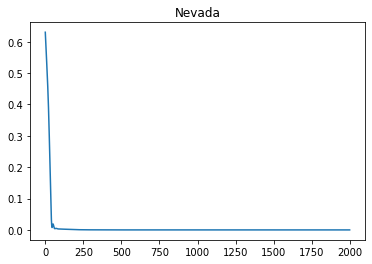

prediction vs actual:
[(tensor([1.2701, 0.1118]), array([1.44      , 0.09993749])),
 (tensor([1.2591, 0.1120]), array([1.42      , 0.10380179])),
 (tensor([1.2382, 0.1121]), array([1.39      , 0.10418387])),
 (tensor([1.2135, 0.1123]), array([1.36      , 0.10777702])),
 (tensor([1.1926, 0.1129]), array([1.3       , 0.10908443])),
 (tensor([1.1770, 0.1141]), array([1.27      , 0.11078337])),
 (tensor([1.1506, 0.1148]), array([1.25      , 0.11196953])),
 (tensor([1.1400, 0.1154]), array([1.26     , 0.1127103])),
 (tensor([1.1357, 0.1173]), array([1.2       , 0.11281062])),
 (tensor([1.1284, 0.1178]), array([1.19      , 0.11358741])),
 (tensor([1.1191, 0.1176]), array([1.17      , 0.11446984])),
 (tensor([1.1100, 0.1178]), array([1.16      , 0.11523303])),
 (tensor([1.1032, 0.1189]), array([1.15      , 0.11667452])),
 (tensor([1.0864, 0.1194]), array([1.13      , 0.11582461])),
 (tensor([1.0762, 0.1187]), array([1.13     , 0.1161092])),
 (tensor([1.0746, 0.1195]), array([1.12    , 0.11672

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch  500 MSE:  3.396570900804363e-05
Epoch  1000 MSE:  1.6203290215344168e-05
Epoch  1500 MSE:  1.1950998668908142e-05


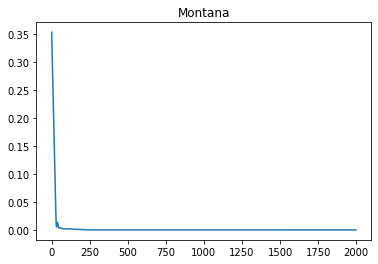

prediction vs actual:
[(tensor([1.2352, 0.0441]), array([1.46      , 0.04229362])),
 (tensor([1.2088, 0.0455]), array([1.42      , 0.04266917])),
 (tensor([1.1754, 0.0456]), array([1.36      , 0.04357963])),
 (tensor([1.1409, 0.0443]), array([1.3       , 0.04290108])),
 (tensor([1.1196, 0.0418]), array([1.26      , 0.04331365])),
 (tensor([1.0984, 0.0415]), array([1.26      , 0.04403535])),
 (tensor([1.0661, 0.0444]), array([1.24      , 0.04566929])),
 (tensor([1.0521, 0.0433]), array([1.24      , 0.04487699])),
 (tensor([1.0403, 0.0418]), array([1.2       , 0.04503817])),
 (tensor([1.0265, 0.0414]), array([1.18     , 0.0439918])),
 (tensor([1.0171, 0.0394]), array([1.14      , 0.04393427])),
 (tensor([0.9971, 0.0389]), array([1.12      , 0.04341972])),
 (tensor([0.9829, 0.0398]), array([1.1       , 0.04330622])),
 (tensor([0.9807, 0.0391]), array([1.06      , 0.04320988])),
 (tensor([0.9764, 0.0374]), array([1.06      , 0.04215799])),
 (tensor([0.9650, 0.0364]), array([1.04      , 0.0

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch  500 MSE:  7.152187026804313e-05


In [0]:
def build_state_model(state):
    for region in [state]:
        print(f"starting {region}")
        input_params = [
            'driving_percent', 'retail_and_recreation_percent_change_from_baseline', 
            'grocery_and_pharmacy_percent_change_from_baseline', 
            'transit_stations_percent_change_from_baseline',
            'workplaces_percent_change_from_baseline', 
            'residential_percent_change_from_baseline', 
            'lockdown_level',
            'hospitalBedCapacity', 'ICUBedsInUse',
            'cumulativeDeaths', 'cumulativeInfected',
            'poverty', 'age', 'income',
            'healthcare', 'healthcareLow', 'healthcareHigh',
            'obesity', 'smokes', 'smokesLow', 'smokesHigh',
            'Density per square mile of land area']
        output_params = ['RtIndicator', 'positive_test_rate']
        seq_len = 30
        X = inputs[region][input_params].values.astype('float32')
        X = preprocessing.StandardScaler().fit(X).transform(X)
        Y = inputs[region][output_params].values.astype('float32')
        X_lstm, y_lstm = sliding_windows(X, Y, seq_len)
        
        hidden1 = 20
        print(len(input_params))
        model = LSTM(len(input_params), hidden_dim1 = hidden1, seq_len = seq_len, output_dim = len(output_params), num_layers=2)

        loss_fn = torch.nn.MSELoss(size_average=True)
        learning_rate = 1e-3
        num_epochs = 2000
        optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        #####################
        # Train model
        #####################
        
        hist = np.zeros(num_epochs)
        losses = [] 
        for t in range(num_epochs):
            # Clear stored gradient

            model.zero_grad()
            
            # Initialise hidden state
            # Don't do this if you want your LSTM to be stateful
            model.hidden = model.init_hidden()
            
            # Forward pass
            y_pred = model(X_lstm)
        
            loss = loss_fn(y_pred, y_lstm)
            losses.append(loss)
            if t % 500 == 0:
                print("Epoch ", t, "MSE: ", loss.item())
            hist[t] = loss.item()
        
            # Zero out gradient, else they will accumulate between epochs
            optimiser.zero_grad()
        
            # Backward pass
            loss.backward()
        
            # Update parameters
            optimiser.step()
        plt.plot(losses)
        plt.title(region)
        plt.show()
        print("prediction vs actual:")
        pprint.pprint(list(zip(y_pred.data, inputs[state][output_params].values[-seq_len:])))

for state in USA:
    build_state_model(state)

all columns available: Index(['region', 'date', 'driving_percent',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'hospitalBedsRequired',
       'hospitalBedCapacity', 'ICUBedsInUse', 'ICUBedCapacity',
       'ventilatorsInUse', 'ventilatorCapacity', 'RtIndicator',
       'RtIndicatorCI90', 'cumulativeDeaths', 'cumulativeInfected',
       'cumulativePositiveTests', 'cumulativeNegativeTests', 'lat', 'long',
       'lockdown_level', 'poverty', 'povertyMoe', 'age', 'ageMoe', 'income',
       'incomeMoe', 'healthcare', 'healthcareLow', 'healthcareHigh', 'obesity',
       'obesityLow', 'obesityHigh', 'smokes', 'smokesLow', 'smokesHigh',
       'Density per square mile of land area', 'Rt_90_lower_bound',
       'Rt_90_up

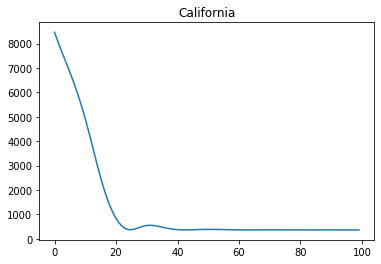

prediction vs actual:
[(tensor([1.4462, 0.1313]), array([1.57      , 0.37899312])),
 (tensor([1.4472, 0.1311]), array([1.5       , 0.38658799])),
 (tensor([1.4545, 0.1302]), array([1.45      , 0.39483725])),
 (tensor([1.4584, 0.1287]), array([1.4      , 0.4009012])),
 (tensor([1.4609, 0.1285]), array([1.31      , 0.40370187])),
 (tensor([1.4620, 0.1282]), array([1.25      , 0.40737069])),
 (tensor([1.4634, 0.1279]), array([1.18      , 0.40835093])),
 (tensor([1.4640, 0.1280]), array([1.18      , 0.40891352])),
 (tensor([1.4644, 0.1280]), array([1.15     , 0.4084725])),
 (tensor([1.4646, 0.1282]), array([1.08     , 0.4080357])),
 (tensor([1.4665, 0.1278]), array([1.02      , 0.40922037])),
 (tensor([1.4671, 0.1278]), array([0.97      , 0.40878161])),
 (tensor([1.4673, 0.1276]), array([0.9       , 0.40771014])),
 (tensor([1.4677, 0.1275]), array([0.89      , 0.40511036])),
 (tensor([1.4681, 0.1274]), array([0.84      , 0.40641468])),
 (tensor([1.4684, 0.1273]), array([0.83      , 0.40372

In [16]:
input_params = [
        'driving_percent', 'retail_and_recreation_percent_change_from_baseline', 
        'grocery_and_pharmacy_percent_change_from_baseline', 
        'transit_stations_percent_change_from_baseline',
        'workplaces_percent_change_from_baseline', 
        'residential_percent_change_from_baseline', 
        'lockdown_level',
        'hospitalBedCapacity', 'ICUBedsInUse',
        'cumulativeDeaths', 'cumulativeInfected',
        'poverty', 'age', 'income',
        'healthcare', 'healthcareLow', 'healthcareHigh',
        'obesity', 'smokes', 'smokesLow', 'smokesHigh',
        'Density per square mile of land area'] + [f'state{i}' for i in range(len(USA))]

inputs_USA = []
for i, (region, region_df) in enumerate(inputs.items()):
    for statenumbervec in range(len(USA)):
        region_df[f"state{statenumbervec}"] = 0
    region_df[f'state{i}'] = 1
    inputs_USA.append(region_df)
inputs_USA = pd.concat(inputs_USA, ignore_index=True)
print(f"all columns available: {inputs_USA.columns}")
print(f"input params: {input_params}")
output_params = ['RtIndicator', 'positive_test_rate']
print(f"output params: {output_params}")
seq_len = 30
X = inputs_USA[input_params].values.astype('float32')
X = preprocessing.MinMaxScaler().fit(X).transform(X)
Y = inputs_USA[output_params].values.astype('float32')
X_lstm, y_lstm = sliding_windows(X, Y, seq_len)

hidden1 = 20
print(len(input_params))
model = LSTM(len(input_params), hidden_dim1 = hidden1, seq_len = seq_len, output_dim = len(output_params), num_layers=2)

loss_fn = torch.nn.MSELoss(reduction='sum')
learning_rate = 2e-3
num_epochs = 2000
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

#####################
# Train model
#####################

hist = np.zeros(num_epochs)
losses = [] 
for t in range(num_epochs):
    # Clear stored gradient

    model.zero_grad()
    
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    model.hidden = model.init_hidden()
    
    # Forward pass
    y_pred = model(X_lstm)

    loss = loss_fn(y_pred, y_lstm)
    losses.append(loss)
    if t % 2 == 0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()
plt.plot(losses)
plt.title(region)
plt.show()
print("prediction vs actual:")
pprint.pprint(list(zip(y_pred.data, inputs['New York'][output_params].values[-seq_len:])))



In [0]:
{param: X_lstm[-1][-1][i] for i, param in enumerate(params)}

{'Density per square mile of land area': tensor(0.),
 'age': tensor(0.),
 'driving_percent': tensor(-0.0139),
 'grocery_and_pharmacy_percent_change_from_baseline': tensor(-0.2063),
 'healthcare': tensor(0.),
 'healthcareHigh': tensor(0.),
 'healthcareLow': tensor(0.),
 'income': tensor(0.),
 'lockdown_level': tensor(0.6364),
 'obesity': tensor(0.),
 'poverty': tensor(0.),
 'residential_percent_change_from_baseline': tensor(0.0215),
 'retail_and_recreation_percent_change_from_baseline': tensor(-0.4084),
 'smokes': tensor(0.),
 'smokesHigh': tensor(0.),
 'smokesLow': tensor(0.),
 'transit_stations_percent_change_from_baseline': tensor(-0.4709),
 'workplaces_percent_change_from_baseline': tensor(-0.6537)}

In [0]:
#import gc; gc.collect()
X_lstm[-1]

tensor([[0.0855, 0.2353, 0.2500, 0.0921, 0.0833, 0.8182, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0983, 0.2353, 0.2778, 0.0921, 0.0694, 0.8182, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1207, 0.2706, 0.3611, 0.1184, 0.0694, 0.8182, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1187, 0.2471, 0.3333, 0.0921, 0.0556, 0.8485, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1503, 0.2118, 0.3056, 0.0789, 0.0556, 0.9394, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1308, 0.2000, 0.3194, 0.1447, 0.2639, 0.5758, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0431, 0.188

In [0]:
params

['driving_percent',
 'retail_and_recreation_percent_change_from_baseline',
 'grocery_and_pharmacy_percent_change_from_baseline',
 'transit_stations_percent_change_from_baseline',
 'workplaces_percent_change_from_baseline',
 'residential_percent_change_from_baseline',
 'lockdown_level',
 'poverty',
 'age',
 'income',
 'healthcare',
 'healthcareLow',
 'healthcareHigh',
 'obesity',
 'smokes',
 'smokesLow',
 'smokesHigh',
 'Density per square mile of land area']

(array([ 5.,  5., 10.,  9.,  3.,  5.,  5.,  2.,  3.,  4.]),
 array([39680. , 43109.1, 46538.2, 49967.3, 53396.4, 56825.5, 60254.6,
        63683.7, 67112.8, 70541.9, 73971. ]),
 <a list of 10 Patch objects>)

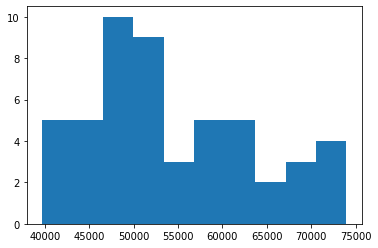

In [0]:
plt.hist([inputs[region]['income'][0] for region in inputs])

array([100.        ,  83.94362926,  70.46532894,  59.15115449,
        49.65362583,  41.68105558,  34.98859077])

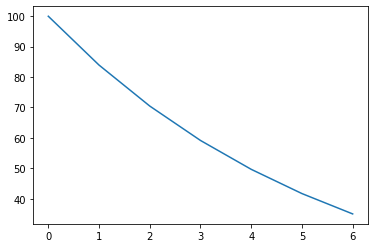

In [0]:
def extrapolate_r0(r0, current_population, timespan=[0,1,2,3,4,5,6]):
    infected = np.power(r0, timespan) * current_population
    plt.plot(infected)
    return infected
extrapolate_r0(y_pred[-1][0].detach().numpy(), 100)

In [0]:
list(zip(inputs['Michigan']['RtIndicator'], y_pred))

[(1.5, tensor(1.4215, grad_fn=<SelectBackward>)),
 (1.5, tensor(1.4188, grad_fn=<SelectBackward>)),
 (1.5, tensor(1.4345, grad_fn=<SelectBackward>)),
 (1.5, tensor(1.6186, grad_fn=<SelectBackward>)),
 (1.5, tensor(1.4126, grad_fn=<SelectBackward>)),
 (1.5, tensor(1.3417, grad_fn=<SelectBackward>)),
 (1.5, tensor(1.5443, grad_fn=<SelectBackward>)),
 (1.5, tensor(1.4663, grad_fn=<SelectBackward>)),
 (1.5, tensor(1.5986, grad_fn=<SelectBackward>)),
 (1.34, tensor(1.7879, grad_fn=<SelectBackward>)),
 (3.6, tensor(3.3485, grad_fn=<SelectBackward>)),
 (3.38, tensor(3.3086, grad_fn=<SelectBackward>)),
 (2.29, tensor(2.3098, grad_fn=<SelectBackward>)),
 (2.15, tensor(2.2105, grad_fn=<SelectBackward>)),
 (2.04, tensor(2.2323, grad_fn=<SelectBackward>)),
 (2.12, tensor(2.2623, grad_fn=<SelectBackward>)),
 (2.36, tensor(2.2564, grad_fn=<SelectBackward>)),
 (2.32, tensor(2.2779, grad_fn=<SelectBackward>)),
 (2.36, tensor(2.3256, grad_fn=<SelectBackward>)),
 (2.32, tensor(2.2340, grad_fn=<SelectBac